In [5]:
import numpy as np
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("../src/")
from data import get_train_val_dataset, get_dataset
from noiseadding import build_noise_transforms, build_noise_transforms2
from PlottingUtil import Plot_model, Plot_predictions_grid, Plot_Full_Robustness
from pathlib import Path
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
idx = {7:'Gaussian',10:'Gaussian (f-k)',8:'Colored',12:'Bandpassed', 9:'Linear',11:'Hyperbolic',
       13:'Lowpass', 14: 'Trace-wise',19:'Gaussian + Linear', 0:'Gaussian + Colored', 1:'Gaussian + Colored + Linear',
       2:'Random + Colored + Linear ',
       3:'Random + Structured + Colored ',
       17:'Linear + Hyperbolic',130:'Lowpass Random',
       -1:'Clean', 4:'X + Lowpass',6:'X + Trace-wise',
       5:'X + Lowpass + Trace-wise'} # add the index of the noise type here

c_limits = [-0.01,0.01]
batch_size=8
workers=4
problem='firstbreak' #firstbreak or denoise

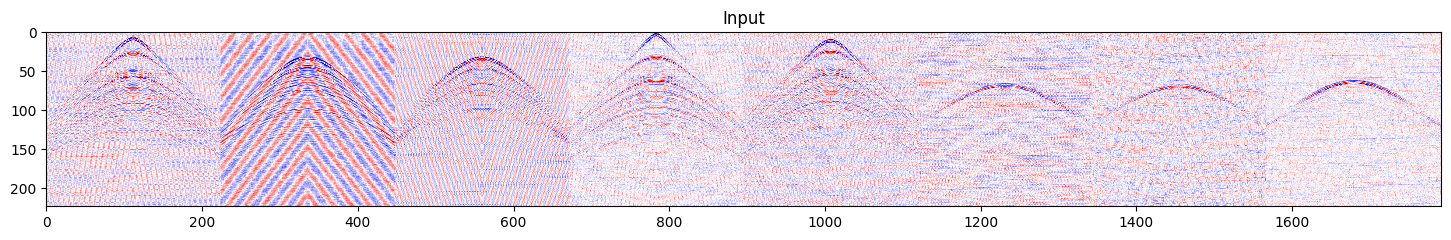

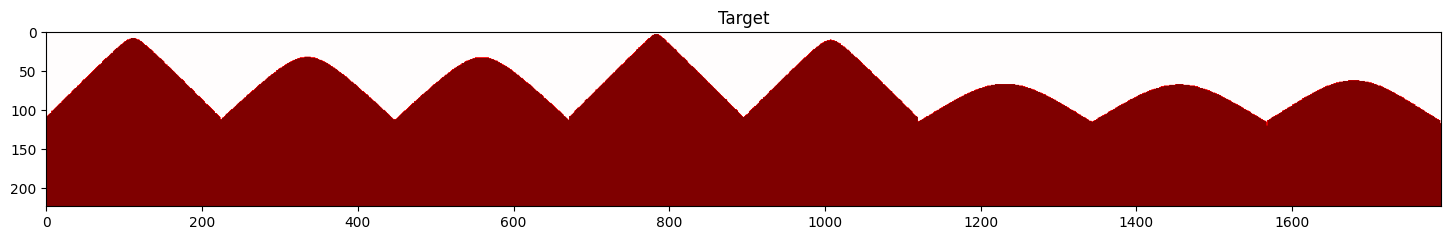

In [7]:
#visualize noise transforms
noise_type=1
noise_scale=0.15
noise_transforms = build_noise_transforms(noise_type, noise_scale)
denoise_dataset = get_dataset(problem, noise_transforms=noise_transforms)
_, val_dataset = get_train_val_dataset(denoise_dataset)
denoise_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
sample = next(iter(denoise_loader))
plt.figure(figsize=(18,9))
plt.imshow(torchvision.utils.make_grid(sample['input'], padding=0)[0][None,...].permute((1, 2, 0)), cmap='seismic',vmin=-1, vmax=1)
plt.title('Input')   
if problem == 'firstbreak':
    plt.figure(figsize=(18,9))
    plt.imshow(torchvision.utils.make_grid(sample['target'].float().unsqueeze(1), padding=0)[0][None,...].permute((1, 2, 0)), cmap='seismic', vmin=-1, vmax=1)   
     
else:
    plt.figure(figsize=(18,9))
    plt.imshow(torchvision.utils.make_grid(sample['target'], padding=0)[0][None, ...].permute((1, 2, 0)), cmap='seismic', vmin=-1, vmax=1)
plt.title('Target')

plt.show()

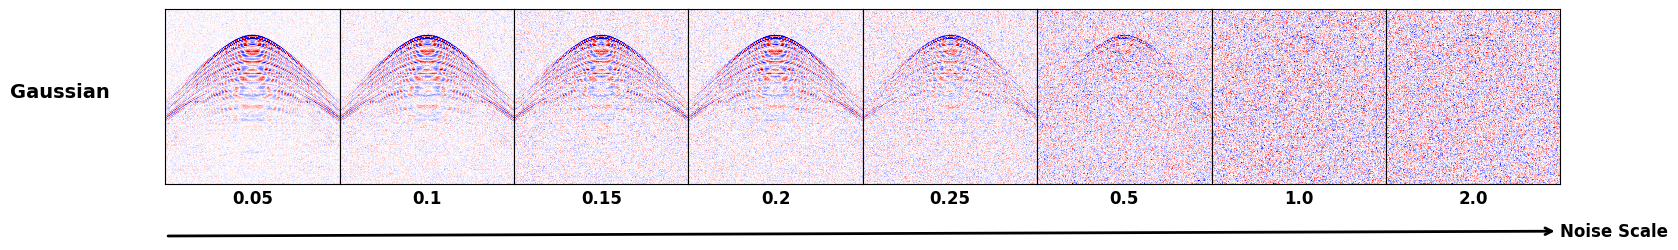

In [8]:
#visualize the effect of noise scale 
i=0
noise_type=7 #noise type

fig, ax= plt.subplots(figsize=(18,8),ncols=8, nrows=1, sharex=True, sharey=True, gridspec_kw = {'wspace':0, 'hspace':0})
for s in [0.05, 0.1,0.15,0.2,0.25,0.5,1.0,2.0]:
    if noise_type==130:
        noise = build_noise_transforms2(noise_type, s,cutoff_std=0.00005)
    else:
        noise = build_noise_transforms(noise_type,s)
    denoise_dataset = get_dataset(problem, noise_transforms=noise)
    _, val_dataset = get_train_val_dataset(denoise_dataset)
    denoise_loader_single = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=workers)

    sample2 = next(iter(denoise_loader_single))

    ax[i].imshow(sample2['input'].squeeze(0,1), cmap='seismic', vmin=-1, vmax=1)

    ax[i].set_yticks([])
    ax[i].set_xticks([])
    ax[i].set_xlabel(s, fontsize=12, fontweight='bold')      

    i=i+1

ax[0].text(-200, 112, idx[noise_type], fontsize=14, fontweight='bold')   

ax[0].annotate('Noise Scale', xy=(0,-0.3), xycoords='axes fraction', xytext=(8,-0.3), arrowprops=dict(arrowstyle="<-", color='k',linewidth=2), fontsize=12, fontweight='bold')
plt.show()


batchsize>1, will display random image from batch
original min/max/mean -1.0 1.0 -0.0014963583
filtered min/max/mean -1.350845901906843 1.222592332022002 -0.0014766111736398248


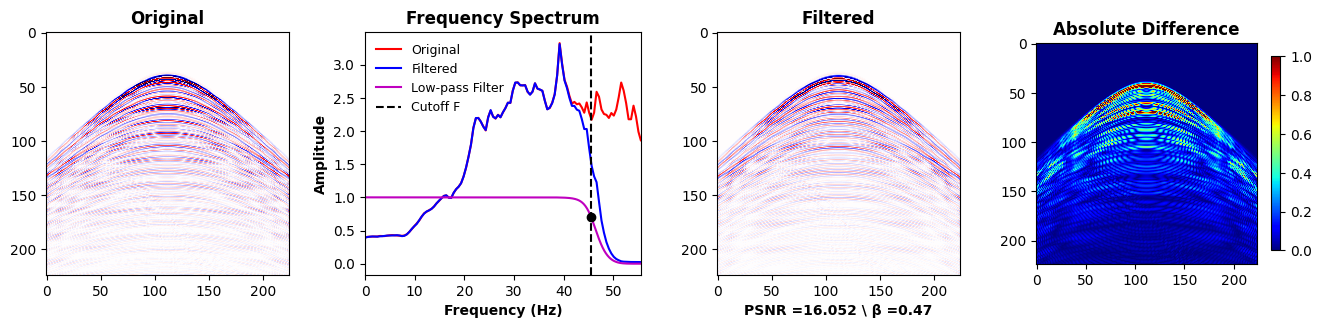

In [6]:
#visualize the effect of lowpass filter
from torch.utils.data import RandomSampler
from noiseadding import LowPassFilter_random
s=0.05
noise = build_noise_transforms2(130,s) 
batch_size=8
problem='denoise'
denoise_dataset = get_dataset(problem, noise_transforms=noise)
sampler=RandomSampler(denoise_dataset, replacement=True,num_samples=batch_size)
denoise_loader_single = DataLoader(denoise_dataset,sampler=sampler,batch_size=batch_size,shuffle=False, num_workers=workers,drop_last=True)

sample = next(iter(denoise_loader_single))

LowPassFilter_random(noise_scale=s).plot(sample['target'])
plt.show()



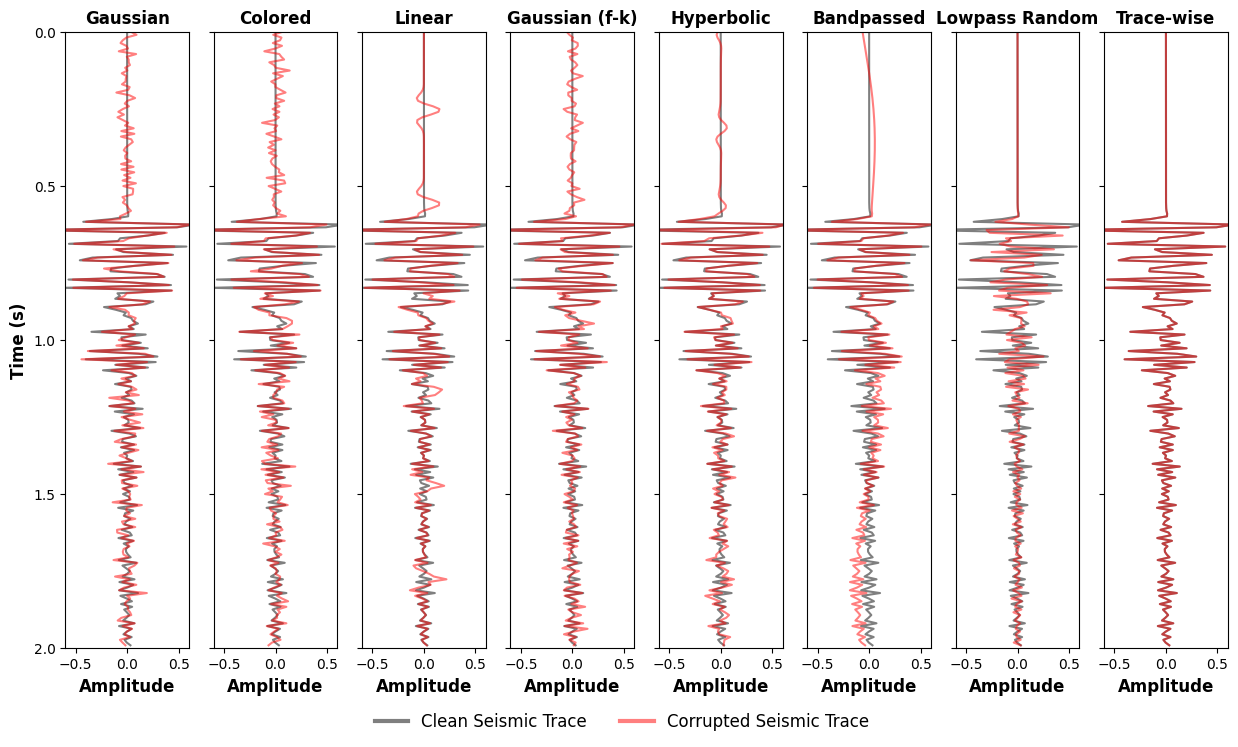

In [7]:

c_limits = [-0.01,0.01]
t=np.arange(0,224,1)
k=50
noise_scale=0.05
batch_size=1
workers=4
problem='denoise'
fig, ax= plt.subplots(figsize=(3,8), ncols=8, nrows=1, sharex= True, sharey=True)
j=0
c=['r','g']
for i in [7,8,9,10,11,12,130,14]:
    if i==130:
        noise = build_noise_transforms2(i, noise_scale,cutoff_std=0.00005)
    else:
        noise = build_noise_transforms(i,noise_scale)
    denoise_dataset = get_dataset(problem, noise_transforms=noise)
    _, val_dataset = get_train_val_dataset(denoise_dataset)
    denoise_loader_single = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)


    sample_n = next(iter(denoise_loader_single))

    ax[j].plot(sample_n['target'].squeeze(0,1)[:,k],t ,'k', label='Data',alpha=0.5 )
    ax[j].plot(sample_n['input'].squeeze(0,1)[:,k],t ,'r', label='+ Noise',alpha=0.5)
   

    ax[j].set_title(idx[i], fontsize=12, fontweight='bold')
    ax[0].set_yticks(np.linspace(0,224,5),np.linspace(0,2,5))
    ax[j].set_xlabel('Amplitude', fontsize=12, fontweight='bold')
    plt.ylim([224,0])
    plt.xlim([-0.6,0.6])
    j=j+1
    
    h,l = ax[0].get_legend_handles_labels()
    #print(np.shape(l))
    L=ax[0].legend([h[0], h[1]],
                     ['Clean Seismic Trace', 'Corrupted Seismic Trace'],
                     loc='upper center', bbox_to_anchor=(4.5, -0.08),
                     fontsize=12,
                     labelcolor='k',facecolor='none',edgecolor='none',ncol=2)  
    
    for b in range (0,2,1):
        L.get_lines()[b].set_linewidth(3)
    ax[0].set_ylabel('Time (s)', fontsize=12, fontweight='bold')

plt.subplots_adjust(right=4)
plt.show()


noise_type2=1  noise_scale2=0.8


Using cache found in /home/alsinasm/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


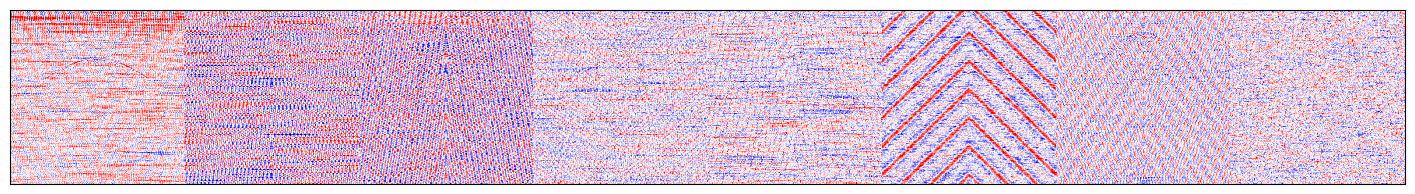

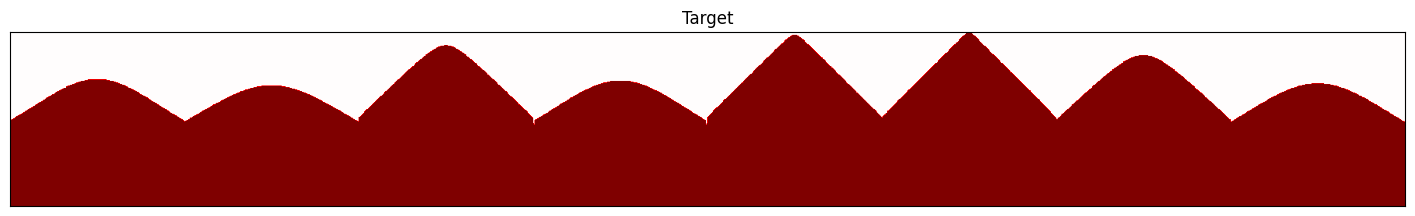

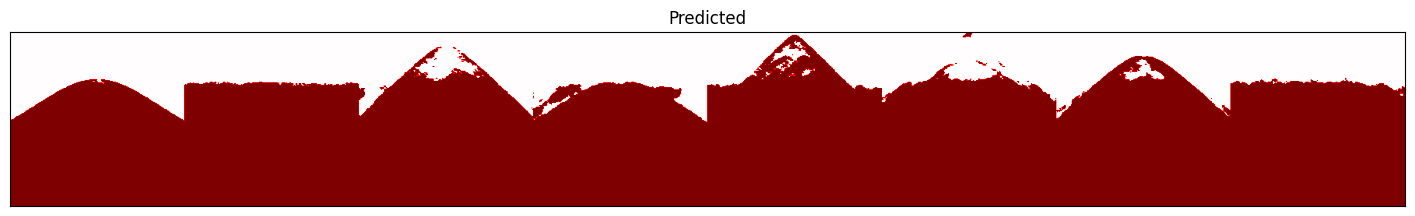

In [ ]:

savefigure=False #save image?
save_path= None # saved in '../images/' otherwise specify the path you want to save images 

#trained model parameters
model_type='unet' #unet, swin, restormer
noise_type=0
noise_scale=0.25
problem='firstbreak'
pretrained=False
attack='none'
folder='../metadata' #location of model pkl

##Noise generator parameters (for testing)
noise_type2=1
noise_scale2=0.8
loader='Validation' # or Train


Plot_model(model_type,problem,noise_type, noise_scale,noise_type2, noise_scale2,attack,pretrained,folder=folder, savefigure=savefigure,loader=loader, save_path=save_path)


noise_type2=19  noise_scale2=1.0


Using cache found in /home/alsinasm/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Using cache found in /home/alsinasm/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Using cache found in /home/alsinasm/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Using cache found in /home/alsinasm/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Using cache found in /home/alsinasm/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Using cache found in /home/alsinasm/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


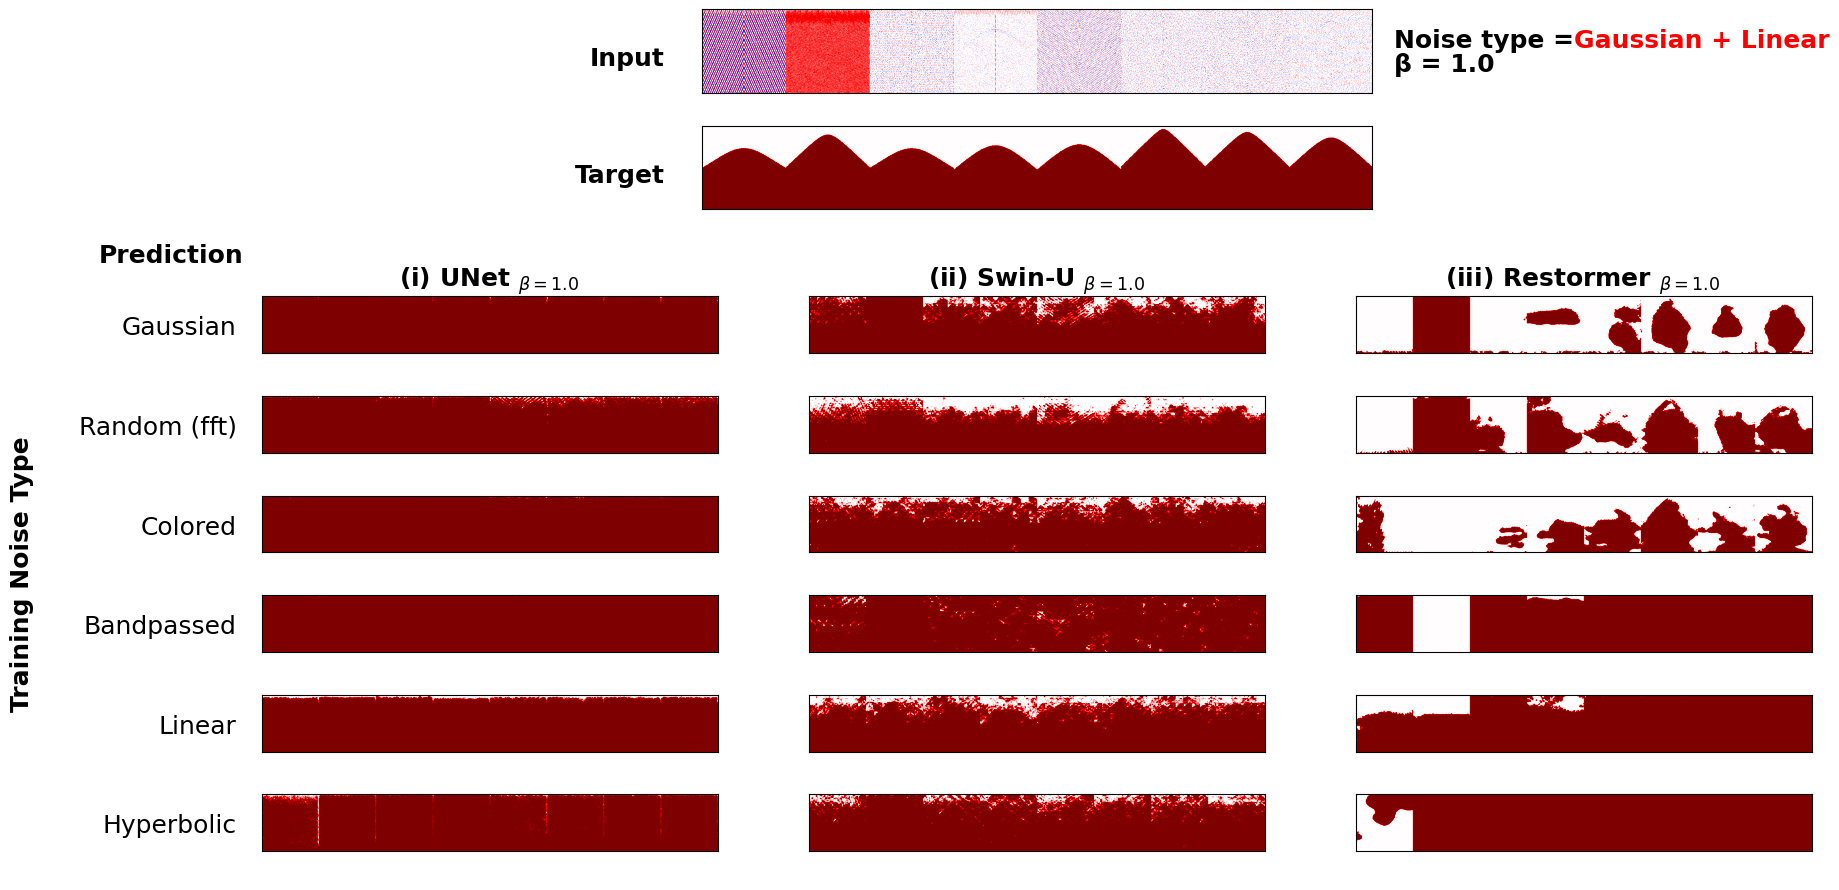

In [ ]:

savefigure=False #save image?
save_path= None # saved in '../images/' otherwise specify the path you want to save images 

#trained model parameters
#noise type is hardcoded internally
noise_scale=0.05 
problem='firstbreak'
pretrained=False
folder='../metadata' #location of model pkl

##Noise generator parameters (for testing)
noise_type2=19
noise_scale2=1.0
loader='Validation' # or Train

Plot_predictions_grid(noise_scale, problem, noise_type2,noise_scale2, folder=folder, save_path=save_path, 
                      savefigure=savefigure,idx=None,loader=loader)

plt.show()


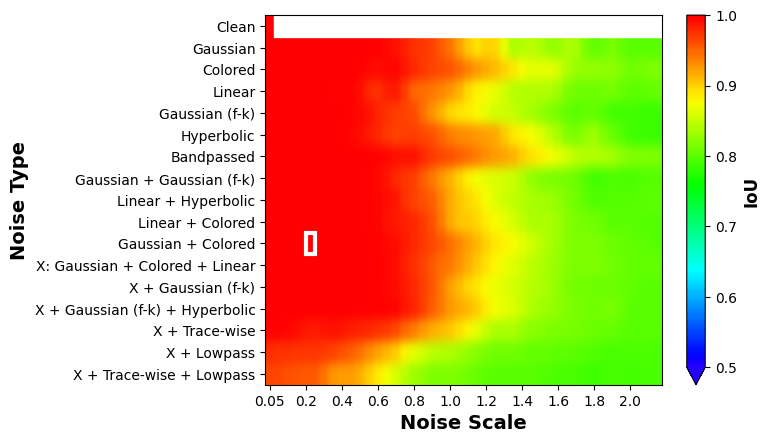

In [9]:
savefigure=False #save image?
save_path= None # saved in '../images/' otherwise specify the path you want to save images 
I='kaiser'# interp method
problem='firstbreak'
model_type= 'unet'
pretrained=False
noise_type=0
attack='none'

epoch=50 #epoch/ make sure you stored your robustness matrix in teh correct location

Plot_Full_Robustness(noise_type=noise_type,problem=problem, model_type=model_type,attack=attack,
                     pretrained=pretrained,scale=[0.25],epoch=epoch,save_path=save_path,savefigure=savefigure,I=I)
plt.show()

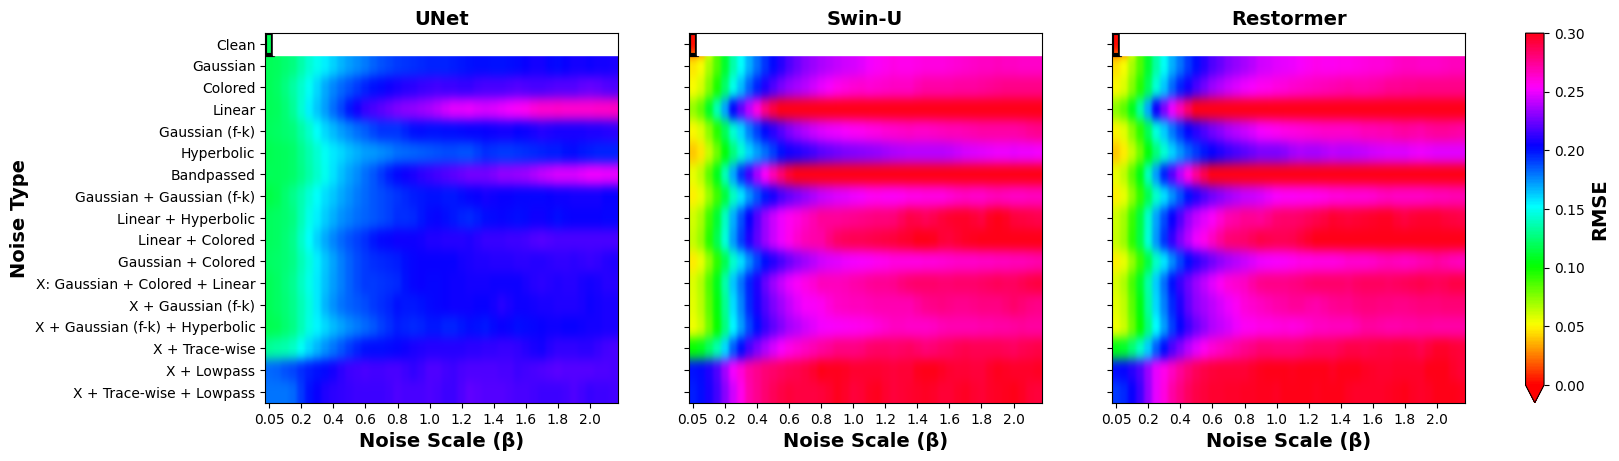

In [9]:


savefigure=False #save image?
save_path= None # saved in '../images/' otherwise specify the path you want to save images 
I='kaiser'# interp method
problem='denoise'
noise_type=-1
scale=0.0

pretrained=False
epoch=100

fig, ax=plt.subplots(ncols=3, nrows=1, sharex=True, sharey=True)

plt.subplot(131)
Plot_Full_Robustness(noise_type=noise_type,problem=problem, model_type='unet',attack=attack,pretrained=pretrained,
                     scale=scale,epoch=epoch,save_path=save_path,savefigure=False,I=I,cb=False)

ax[0].set_title('UNet', fontsize=14, weight='bold')
plt.subplot(132)
Plot_Full_Robustness(noise_type=noise_type,problem=problem, model_type='swin',attack=attack,pretrained=pretrained,
                     scale=scale,epoch=epoch,save_path=save_path,savefigure=False,I=I,cb=False)

ax[1].set_title('Swin-U', fontsize=14, weight='bold')
plt.subplot(133)
im,_=Plot_Full_Robustness(noise_type=noise_type,problem=problem, model_type='restormer',attack=attack,pretrained=pretrained,
                          scale=scale,epoch=epoch,save_path=save_path,savefigure=False,I=I,cb=False)
ax[2].set_title('Restormer', fontsize=14, weight='bold')
for i in range (1,3,1):
    ax[i].set_ylabel('')

for i in range (0,3,1):
    ax[i].set_xlabel('Noise Scale (\u03B2)')


if problem=='denoise':
    fig.colorbar(im, ax= ax[0:],orientation='vertical',extend='min', pad=0.005, anchor=(15,-3)).set_label('RMSE',size=14, weight='bold', color='k')
else:
    fig.colorbar(im, ax= ax[0:],orientation='vertical',extend='max', pad=0.005, anchor=(15,-3)).set_label('mIoU',size=14, weight='bold', color='k')

plt.subplots_adjust(right=2)

if savefigure == True: 
    if save_path is None:
            save_path = Path(f"../images/Robustness/")
            save_path.mkdir(parents=True, exist_ok=True)

    plt.savefig(f'{save_path}/Compare_{epoch}E_Full_Robustness_Matrix_Interpolated_{I}_noisetype{noise_type}_noisescale_{scale}_{problem}_attack_{attack}_{pretrained}.jpg',dpi=1000, bbox_inches='tight',transparent=True)

plt.show()

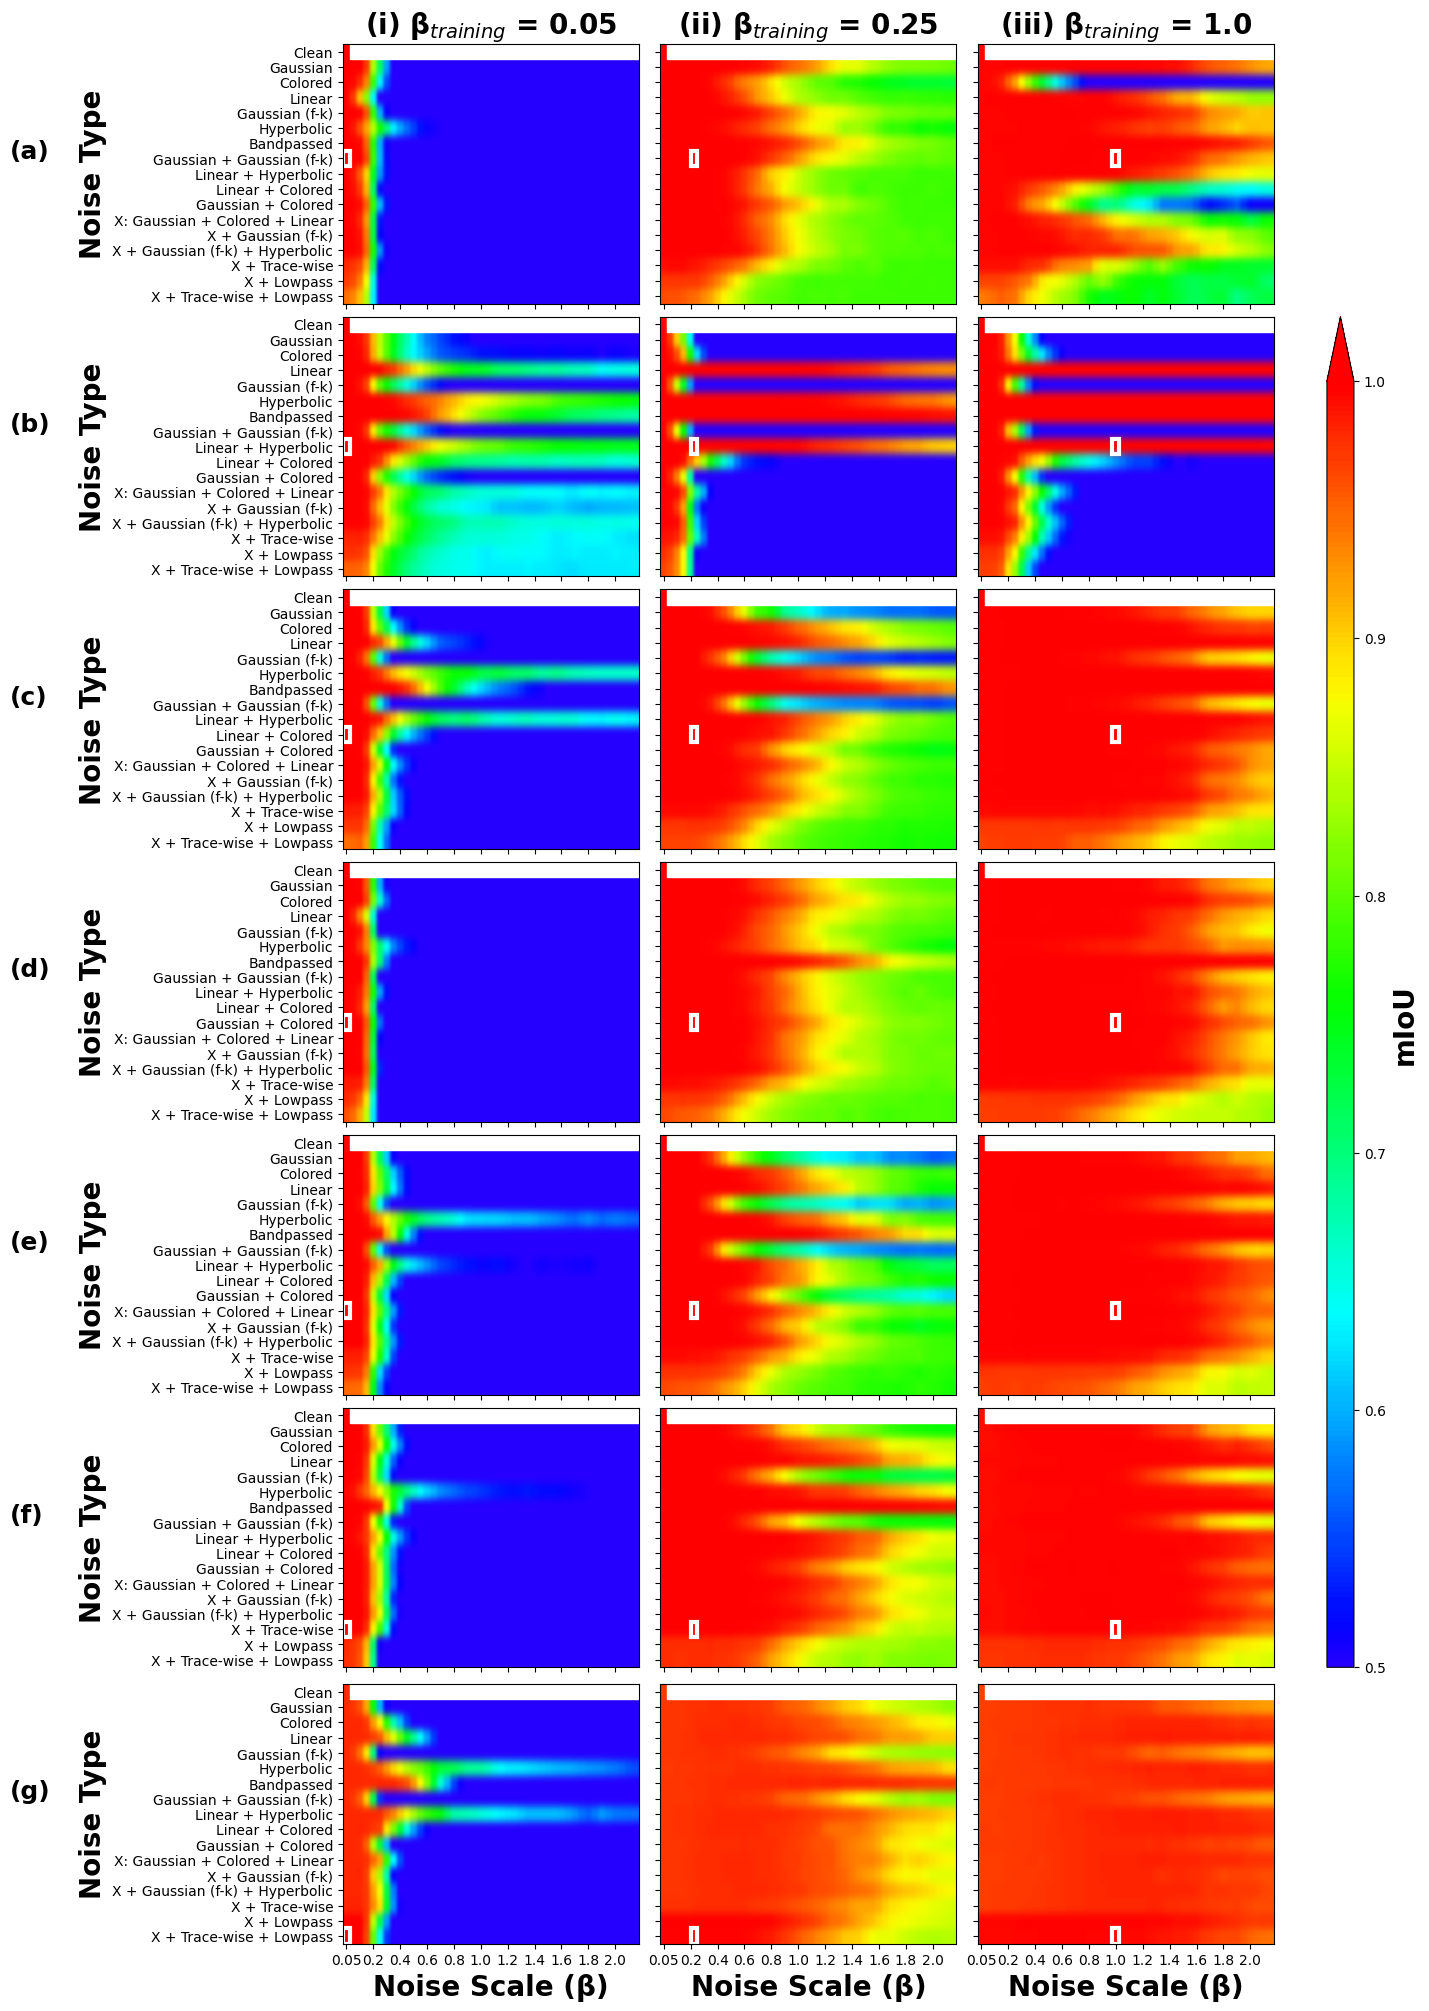

In [12]:

savefigure=False #save image?
save_path= None # saved in '../images/' otherwise specify the path you want to save images 
I='kaiser'# interp method
problem='firstbreak'
model_type='unet'
pretrained=False
epoch=50
attack='none'

#selct noise group
N_group ='Compound'

if N_group == 'Single':
     N=[7,10,8,12,9,11] # Single Noise
else:
     N=[16,17,18,0,1,6,5] # Compound Noise

i=0
x=len(N) #
fig, axs=plt.subplots(ncols=3, nrows=x, sharex=True, sharey=True,figsize=(15,20),constrained_layout=True)
ax=axs.flatten()
for n in N:
    plt.subplot(x,3,1+i)
    _,_=Plot_Full_Robustness(noise_type=n,problem=problem, model_type=model_type,attack=attack,pretrained=pretrained,
                          scale=[0.05],epoch=epoch,save_path=save_path,savefigure=False,I=I,cb=False)

    plt.subplot(x,3,2+i)

    _,_=Plot_Full_Robustness(noise_type=n,problem=problem, model_type=model_type,attack=attack,pretrained=pretrained,
                          scale=[0.25],epoch=epoch,save_path=save_path,savefigure=False,I=I,cb=False)

    plt.subplot(x,3,3+i)
   
    im, _=Plot_Full_Robustness(noise_type=n,problem=problem, model_type=model_type,attack=attack,pretrained=pretrained,
                          scale=[1.0],epoch=epoch,save_path=save_path,savefigure=False,I=I,cb=False)
  
    i+=3

for i in range (0,len(ax),1):
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')

for i in range (len(ax)-3,len(ax),1):
    ax[i].set_xlabel('Noise Scale (\u03B2)', fontsize=20, fontweight='bold')

letters=['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p']
j=0
for i in range(0,len(ax),3):#[0,3,6,9,12,15]:
    ax[i].set_ylabel('Noise Type', fontsize=20, fontweight='bold')
    ax[i].text(-50,7, f'({letters[j]})', fontsize=18, fontweight='bold')
    j+=1


ax[0].set_title('(i) \u03B2$_{training}$ = 0.05', fontsize=20, weight='bold')
ax[1].set_title('(ii) \u03B2$_{training}$ = 0.25', fontsize=20, weight='bold')
ax[2].set_title('(iii) \u03B2$_{training}$ = 1.0', fontsize=20, weight='bold')


if problem=='denoise':
    cbar=fig.colorbar(im, ax= ax[4:len(ax)-4],orientation='vertical',extend='max', pad=0.1, anchor=(3,0),aspect=50)
    cbar.ax.tick_params(labelsize=18)
    cbar.set_label('RMSE',size=14, weight='bold', color='k')
else:
    cbar=fig.colorbar(im, ax= ax[4:len(ax)-4],orientation='vertical',extend='max', pad=0.1, anchor=(3,0),aspect=50)
    cbar.set_label('mIoU',size=20, weight='bold', color='k')

if savefigure == True: 
    if save_path is None:
            save_path = Path(f"../images/Robustness/{N_group}")
            save_path.mkdir(parents=True, exist_ok=True)

    plt.savefig(f'{save_path}/Compare_{epoch}E_Full_Robustness_Matrix_Interpolated_{I}_noisetype{noise_type}_noisescale_{scale}_{problem}_attack_{attack}_{pretrained}.jpg',dpi=1000, bbox_inches='tight',transparent=True)

plt.show()